In [1]:
import pandas as pd


df = pd.read_csv("data/inflation.csv", parse_dates=True, index_col="Month")
df = df[df.index >= "2005-01-01"]
df.head()

,Inflation
Month,
2005-01-01,7.3
2005-02-01,7.3
2005-03-01,7.1
2005-04-01,7.2
2005-05-01,7.3


In [ ]:
# Holt winter
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from utils import split_fixed, get_metrics, split_ratio
from models import holt_win_search


train, test = split_ratio(df)

holt_win_search(train, test)

Split -- Total: 240, Train: 192, Test: 48


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473

<class 'pandas.core.frame.DataFrame'>


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Trend,Seasonality,BoxCox,MAPE (%),MAE,MSE
3,multiplicative,additive,False,30.104,1.659065,5.046544
2,multiplicative,additive,True,32.000,1.789335,5.683109
0,multiplicative,multiplicative,True,40.236,2.200262,7.813802
7,additive,additive,False,190.587,6.951737,75.716269
6,additive,additive,True,251.577,9.103180,140.113597
5,additive,multiplicative,False,256.915,9.588360,136.136247
4,additive,multiplicative,True,478.391,17.760325,504.995274
1,multiplicative,multiplicative,False,5488.016,176.624346,90519.133790


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


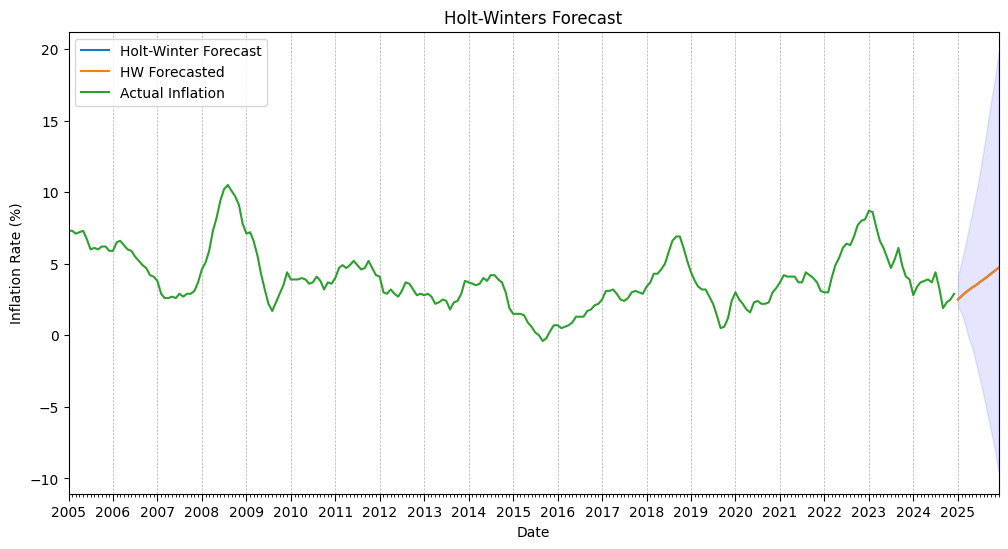

In [3]:
# Apply to whole data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

alpha = df.min().iloc[0] + 1
modelMul = ExponentialSmoothing(
    df ,
    seasonal_periods=12,
    trend="additive",
    seasonal="additive",
    use_boxcox=False,
).fit()

f = modelMul.forecast(12) - alpha

n_steps_prediction = 12 
n_repetitions = 1000

df_simul = modelMul.simulate(
    nsimulations=n_steps_prediction,
    repetitions=n_repetitions,
    anchor='end',
)

upper_ci = df_simul.quantile(q=0.975, axis='columns')
lower_ci = df_simul.quantile(q=0.025, axis='columns')

fig, ax = plt.subplots(figsize=(12, 6))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Optional: format ticks
ax.tick_params(axis='x', which='major', length=5)  # major ticks
ax.tick_params(axis='x', which='minor', length=2)  # minor ticks, no labels
ax.grid(axis="x", linestyle='--', linewidth=0.5)
ax.set_xlim(df.index.min(), f.index.max())
ax.plot(f, label="Holt-Winter Forecast")
ax.set_title("Holt-Winters Forecast")
ax.set_ylabel("Inflation Rate (%)")
ax.set_xlabel("Date")

ax.plot(f,label="HW Forecasted")
ax.plot(df["Inflation"], label="Actual Inflation")
ax.fill_between(f.index, lower_ci, upper_ci, color='blue', alpha=0.1)
plt.legend()
plt.show()


,lb_stat,lb_pvalue
1,4.356871,3.685994e-02
2,13.817450,9.990308e-04
3,14.245826,2.588938e-03
4,26.076458,3.054087e-05
5,30.282579,1.297495e-05
6,30.296288,3.452409e-05
7,36.941713,4.811423e-06
8,38.253461,6.758418e-06
9,39.350016,9.961140e-06
10,41.586889,8.880033e-06


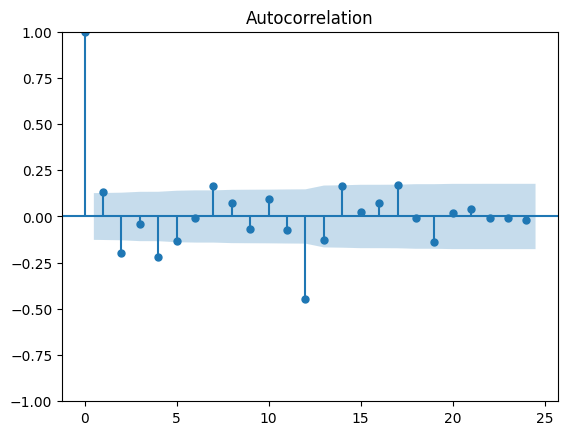

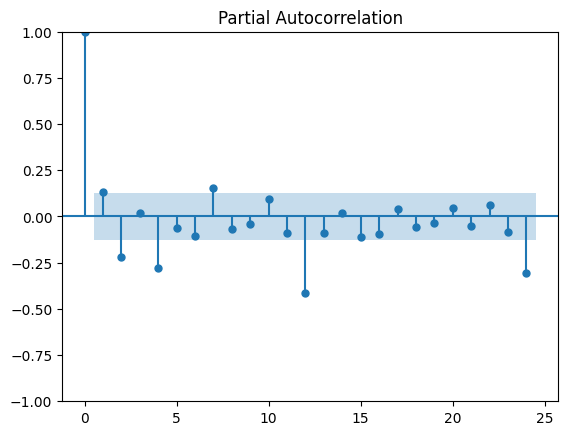

In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(modelMul.resid)
_ = plot_pacf(modelMul.resid )
acorr_ljungbox(modelMul.resid, lags=24)